# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Firman Maulana
- **Email:** mfirman4674@gmail.com
- **ID Dicoding:** -

In [33]:
# pip install tensorflowjs

## Import Semua Packages/Library yang Digunakan

In [34]:
import os
import kagglehub
import shutil
import random
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Data Loading

In [35]:
# from google.colab import files
# files.upload()

In [36]:
# import os
# os.makedirs('/root/.kaggle', exist_ok=True)
# !cp kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

In [37]:
# #Download dataset dari Kaggle
# !kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset
# # Ekstrak file zip
# !unzip -q emotion-recognition-dataset.zip -d emotion_dataset

Jumlah gambar per kelas: {'Neutral': 3947, 'Sad': 3824, 'Happy': 3637}
Rata-rata ukuran gambar: 497x529


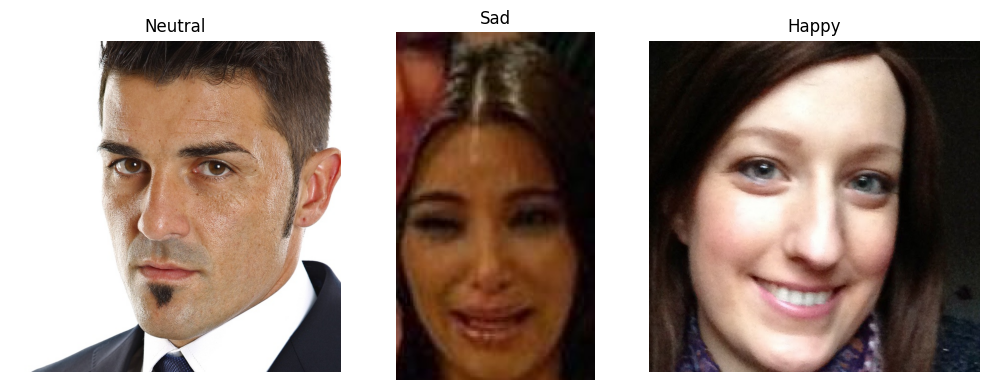

In [38]:
# Path dataset
dataset_path = "/content/emotion_dataset/dataset"
selected_classes = ['Neutral', 'Sad', 'Happy']

image_counts = {}
widths, heights = [], []
example_images = {}

# Loop per kelas
for cls in selected_classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    image_counts[cls] = len(images)

    # Ambil 1 gambar contoh
    img_path = os.path.join(class_path, images[0])
    with Image.open(img_path) as img:
        widths.append(img.width)
        heights.append(img.height)
        example_images[cls] = img.copy()

# Cetak info
print("Jumlah gambar per kelas:", image_counts)
print(f"Rata-rata ukuran gambar: {sum(widths)//len(widths)}x{sum(heights)//len(heights)}")

# Tampilkan 1 gambar per kelas
plt.figure(figsize=(10, 4))
for i, (label, img) in enumerate(example_images.items()):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Split Dataset

In [39]:
# Parameter
IMG_SIZE = (128,128)
BATCH_SIZE = 32
SPLIT_RATIO = (0.7, 0.15, 0.15)

#Split dataset ke dalam folder train/val/test
SOURCE_DIR = "/content/emotion_dataset/dataset"
TARGET_BASE = "/content/emotion_dataset/split_data"

for cls in selected_classes:
    src_folder = os.path.join(SOURCE_DIR, cls)
    all_files = os.listdir(src_folder)
    random.shuffle(all_files)

    total = len(all_files)
    train_end = int(total * SPLIT_RATIO[0])
    val_end = train_end + int(total * SPLIT_RATIO[1])

    splits = {
        'train': all_files[:train_end],
        'val': all_files[train_end:val_end],
        'test': all_files[val_end:]
    }

    for split_name, files in splits.items():
        dst_folder = os.path.join(TARGET_BASE, split_name, cls)
        os.makedirs(dst_folder, exist_ok=True)
        for file in tqdm(files, desc=f"Copying {cls} to {split_name}"):
            shutil.copy(os.path.join(src_folder, file), os.path.join(dst_folder, file))

Copying Happy to test: 100%|██████████| 561/561 [00:00<00:00, 1467.72it/s]


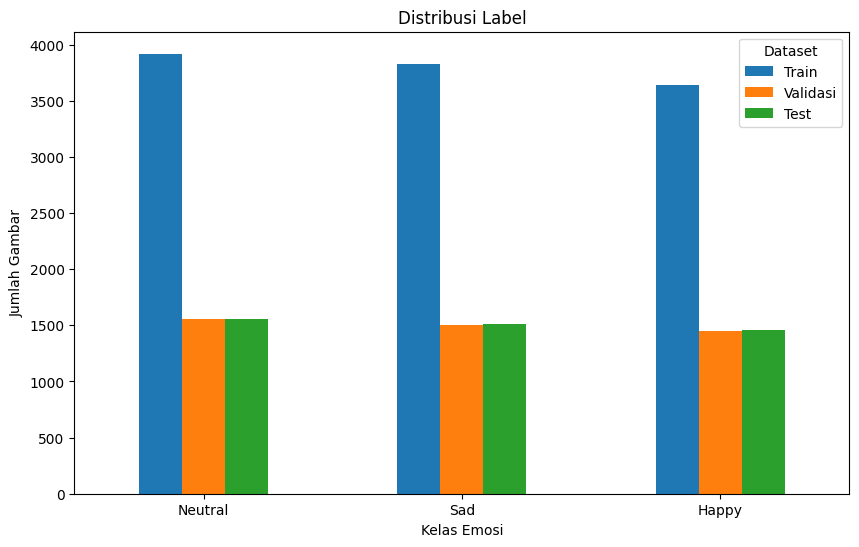

In [40]:
# Menghitung jumlah gambar per kelas dalam setiap set (train, val, test)
train_counts = {}
val_counts = {}
test_counts = {}

for cls in selected_classes:
    train_counts[cls] = len(os.listdir(os.path.join(TARGET_BASE, "train", cls)))
    val_counts[cls] = len(os.listdir(os.path.join(TARGET_BASE, "val", cls)))
    test_counts[cls] = len(os.listdir(os.path.join(TARGET_BASE, "test", cls)))

# Membuat DataFrame untuk visualisasi
df_dist = pd.DataFrame({
    'Kelas': selected_classes,
    'Train': train_counts.values(),
    'Validasi': val_counts.values(),
    'Test': test_counts.values()
})

# Menampilkan distribusi label menggunakan bar plot
df_dist.plot(x='Kelas', kind='bar', figsize=(10, 6))
plt.title('Distribusi Label')
plt.xlabel('Kelas Emosi')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.show()

In [41]:
#Augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)
train = train_datagen.flow_from_directory(os.path.join(TARGET_BASE, "train"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val = val_test_datagen.flow_from_directory(os.path.join(TARGET_BASE, "val"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test = val_test_datagen.flow_from_directory(os.path.join(TARGET_BASE, "test"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

num_classes = len(train.class_indices)

Found 11387 images belonging to 3 classes.
Found 4514 images belonging to 3 classes.
Found 4528 images belonging to 3 classes.


## Modelling

In [42]:
#Model CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,923 (12.61 MB)

 Trainable params: 3,305,475 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

In [45]:
#Training
history = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=callbacks
)

Epoch 1/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 88s 227ms/step - accuracy: 0.5113 - loss: 1.3348 - val_accuracy: 0.5629 - val_loss: 0.8797 - learning_rate: 0.0010
Epoch 2/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.6927 - loss: 0.6571 - val_accuracy: 0.6238 - val_loss: 0.7448 - learning_rate: 0.0010
Epoch 3/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 71s 199ms/step - accuracy: 0.7481 - loss: 0.5616 - val_accuracy: 0.7840 - val_loss: 0.5064 - learning_rate: 0.0010
Epoch 4/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.7871 - loss: 0.4774 - val_accuracy: 0.7415 - val_loss: 0.5466 - learning_rate: 0.0010
Epoch 5/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.8083 - loss: 0.4394 - val_accuracy: 0.7614 - val_loss: 0.5452 - learning_rate: 0.0010
Epoch 6/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.8295 - loss: 0.3998 - val_accuracy: 0.7164 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 7/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.8

In [46]:
#Accuracy
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc:.2%}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9910 - loss: 0.0447
Test Accuracy: 97.92%


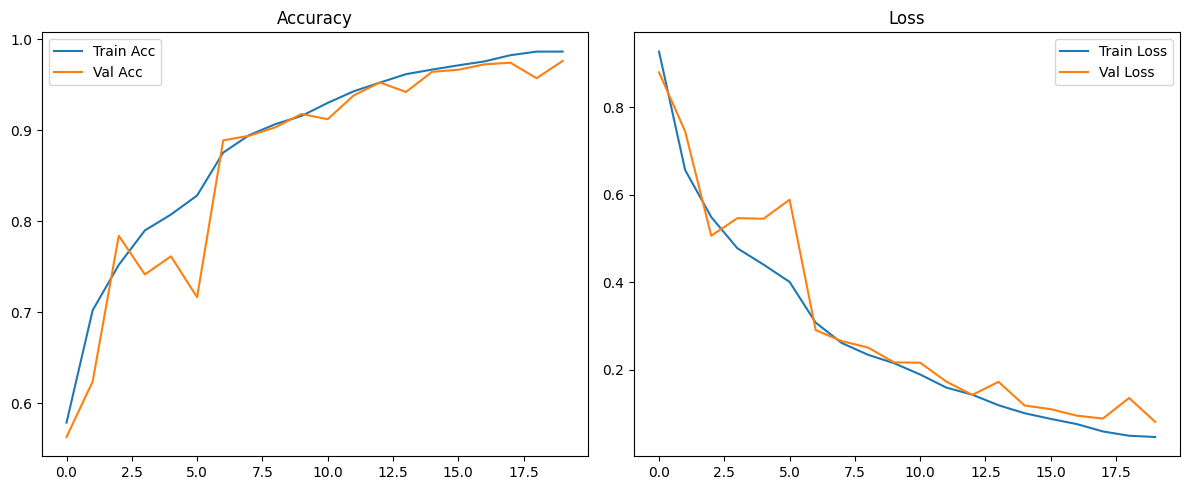

In [47]:
#Visualization
plt.figure(figsize=(12, 5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step


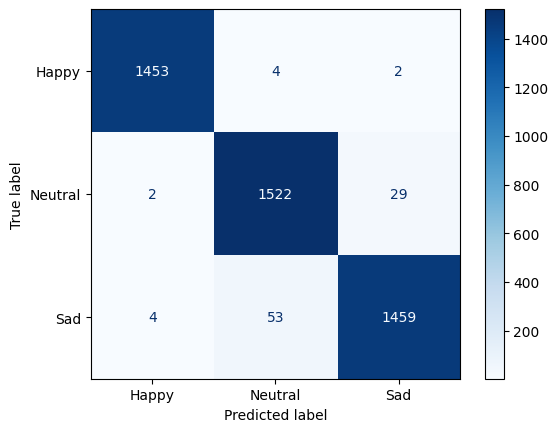

In [48]:
#Confussion Matrix
y_pred = model.predict(test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.show()


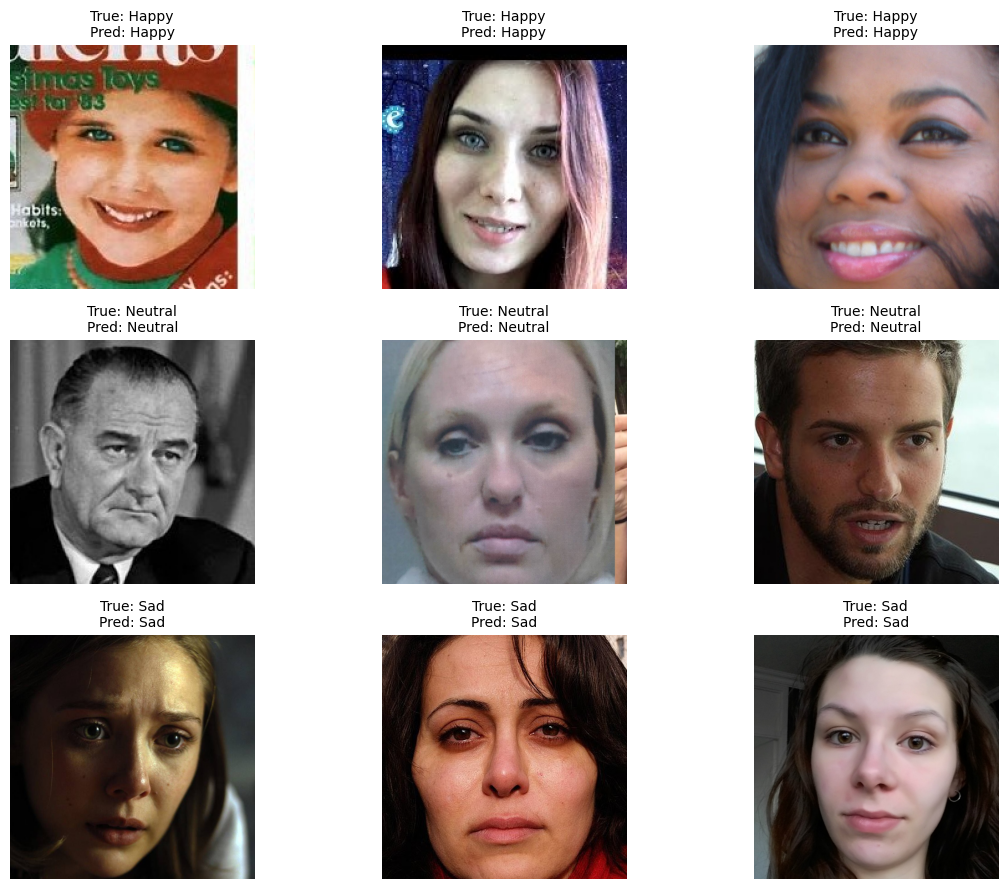

In [49]:
y_true = test.classes
filenames = test.filenames
class_names = list(test.class_indices.keys())
test_dir = test.directory

# Dictionary untuk menyimpan gambar per kelas yang diprediksi dengan benar
found_classes = {label: [] for label in class_names}
for i in range(len(filenames)):
    true_idx = y_true[i]
    pred_idx = y_pred[i]

    if true_idx == pred_idx:  # Prediksi benar
        true_label = class_names[true_idx]
        pred_label = class_names[pred_idx]

        if len(found_classes[true_label]) < 3:
            found_classes[true_label].append((filenames[i], pred_label))

# Tampilkan gambar asli dengan label asli dan prediksi
plt.figure(figsize=(12, len(class_names) * 3))
count = 1

for label in class_names:
    for img_name, pred_label in found_classes[label]:
        img_path = os.path.join(test_dir, img_name)
        img = Image.open(img_path)

        plt.subplot(len(class_names), 3, count)
        plt.imshow(img)
        plt.title(f"True: {label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')
        count += 1

plt.tight_layout()
plt.show()

## Konversi Model

In [50]:
# Menyimpan model sebagai savedmodel
tf.saved_model.save(model, 'saved_model')

In [51]:
# Buat folder output
os.makedirs('tfjs_model', exist_ok=True)

# Simpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [52]:
# Menyimpan model sebagai tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

# Buat file label.txt dari class_names
with open('tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")


Saved artifact at '/tmp/tmpr1hcat4s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137280132708304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043899152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043896848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043897424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043900688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043899344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043896272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043894352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043894160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137280043895888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13728004389

In [58]:
from google.colab import files

# Download Folder vegetable_model (save model)
!zip -r saved_model.zip saved_model
files.download('saved_model.zip')

# Download File TF-Lite
!zip -r tflite.zip tflite
files.download('tflite.zip')

# Download Folder tfjs_model
!zip -r tfjs_model.zip tfjs_model
files.download('tfjs_model.zip')

  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 67%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 89%)
  adding: saved_model/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 8%)
  adding: tflite/label.txt (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard4of4.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of4.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 88%)
  adding: tfjs_model/group1-shard1of4.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of4.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

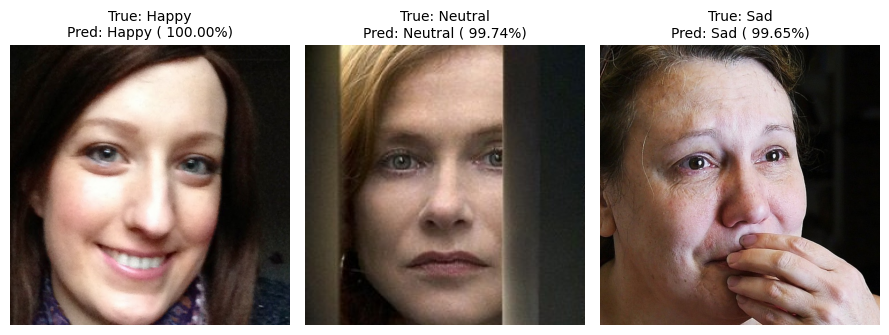

In [57]:
# Memuat model yang disimpan
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')

# Contoh class_names
class_names = ['Happy', 'Neutral', 'Sad']
# Konfigurasi
class_names = list(test.class_indices.keys())
test_dir = test.directory

# Fungsi prediksi
def predict_image(img_path, model, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    output = model(img_array)
    prediction = model(img_array)
    pred_index = np.argmax(prediction)
    confidence = np.max(prediction)

    return class_names[pred_index], float(confidence)

# Visualisasi gambar per kelas
plt.figure(figsize=(len(class_names) * 3, 4))

for idx, label in enumerate(class_names):
    label_dir = os.path.join(test_dir, label)
    img_list = [f for f in os.listdir(label_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if img_list:
        img_path = os.path.join(label_dir, img_list[0])
        pred_label, confidence = predict_image(img_path, model)

        # Tampilkan gambar asli (warna)
        img = Image.open(img_path)
        plt.subplot(1, len(class_names), idx + 1)
        plt.imshow(img)
        plt.title(f"True: {label}\nPred: {pred_label} ({confidence: .2%})", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()
